<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1000 non-null   int64  
 1   sex        1000 non-null   int64  
 2   HTN        1000 non-null   int64  
 3   DM         1000 non-null   int64  
 4   LDL        1000 non-null   float64
 5   HDL        1000 non-null   float64
 6   TG         1000 non-null   float64
 7   HbA1c      1000 non-null   float64
 8   BMI        1000 non-null   float64
 9   smoking    1000 non-null   int64  
 10  statin     1000 non-null   int64  
 11  CACS       1000 non-null   float64
 12  CACS_high  1000 non-null   int64  
dtypes: float64(6), int64(7)
memory usage: 101.7 KB
AUC: 0.8627238850823415
              precision    recall  f1-score   support

           0       0.66      0.56      0.61        59
           1       0.83      0.88      0.85       141

    accuracy                           0.79       200


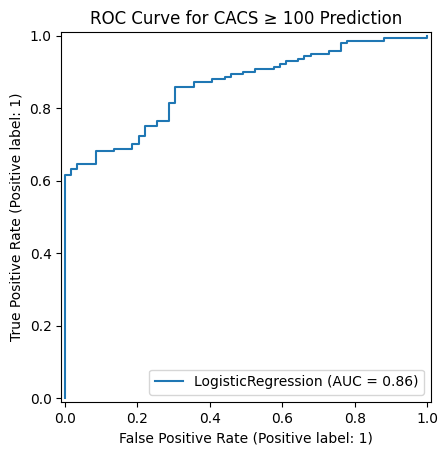

C:\Users\duih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:183: UserWarning: [19:59:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


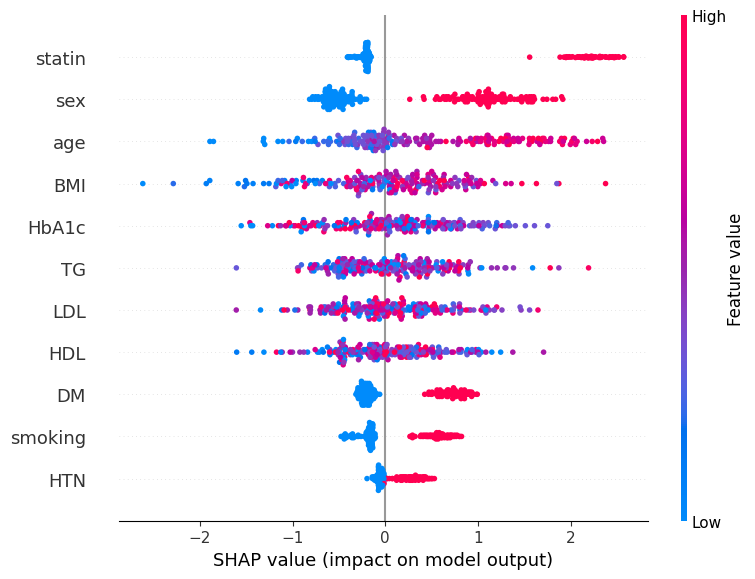

AttributeError: 'numpy.ndarray' object has no attribute 'base_values'

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
# CSV 파일 불러오기
df = pd.read_csv("CDW_CACS_example_regenerated.csv")

# 상위 5개 확인
df.head()
# 변수 요약
df.info()

# 타겟 분포 확인 (CACS ≥ 100 여부)
df["CACS_high"].value_counts()
X = df[["age", "sex", "HTN", "DM", "LDL", "HDL", "TG", "HbA1c", "BMI", "smoking", "statin"]]
y = df["CACS_high"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve for CACS ≥ 100 Prediction")
plt.show()

# 로지스틱 회귀 계수 해석
import pandas as pd

# 변수 이름과 계수 추출
coefficients = pd.Series(model.coef_[0], index=X.columns)
coefficients_sorted = coefficients.sort_values(key=abs, ascending=False)

# 저장
coef_path = "/mnt/data/logistic_coefficients.csv"
coefficients_sorted.to_csv(coef_path)

coefficients_sorted, coef_path

import shap
from xgboost import XGBClassifier

# 1. XGBoost 모델 학습
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# 2. SHAP Explainer 생성 및 값 계산
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# 3. Summary Plot (변수 영향도 시각화)
shap.summary_plot(shap_values, X_test)

shap.initjs()
shap.force_plot(
    shap_values[0].base_values,
    shap_values[0].values,
    shap_values[0].data,
    feature_names=X_test.columns
)

import shap

# 1. SHAP 최신 방식으로 explainer 정의
explainer = shap.Explainer(xgb_model, X_train)

# 2. Explanation 객체 반환
shap_values = explainer(X_test)
# 3. 첫 번째 환자 force plot
shap.initjs()
shap.force_plot(shap_values[0])
